<a href="https://colab.research.google.com/github/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/IA_Image_Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

     |████████████████████████████████| 48.4 MB 31 kB/s 
--2021-08-30 19:59:37--  https://github.com/yeatmanlab/AFQ/raw/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t1_tal_nlin_asym_09a.nii
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yeatmanlab/AFQ/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t1_tal_nlin_asym_09a.nii [following]
--2021-08-30 19:59:37--  https://raw.githubusercontent.com/yeatmanlab/AFQ/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t1_tal_nlin_asym_09a.nii
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17350930 (17M) [application

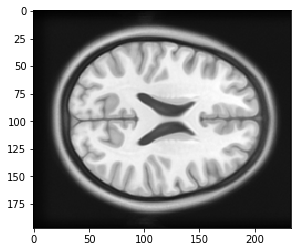

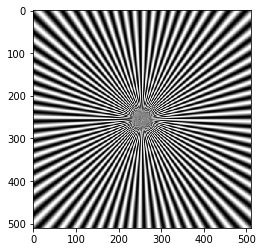

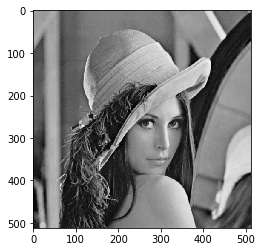

In [1]:
!pip install SimpleITK
!wget https://github.com/yeatmanlab/AFQ/raw/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t1_tal_nlin_asym_09a.nii
!wget https://github.com/yeatmanlab/AFQ/raw/master/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t2_tal_nlin_asym_09a.nii
!wget https://www.spiedigitallibrary.org/ContentImages/Journals/OPEGAR/54/7/074104/WebImages/OE_54_7_074104_f001.png
!wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

# np.random.seed(42)


import os,sys, math, time , requests
import cv2, scipy, scipy.special

#supported values are ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
#matplotlib.use("Qt5Agg")
#print(matplotlib.matplotlib_fname())
import matplotlib.pyplot as plt

import numpy as np
import SimpleITK as sitk
import nibabel as nib

from PIL import Image
from io import BytesIO
from functools import partial
from scipy.interpolate import splev, splrep
from scipy.interpolate import BSpline

sys.setrecursionlimit(15000)

# from google.colab import drive
# drive.mount('/content/drive')


import SimpleITK as sitk 

# plotting lib
import matplotlib.pyplot as plt  # the Python plotting package
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_fdata()
 # Show the images by stacking them left-right with hstack
t1_slice = t1_data[:, :, 94]
plt.imshow(t1_slice)

# using SimpleITK
fixedPath  = "mni_icbm152_t1_tal_nlin_asym_09a.nii"
f3d = sitk.GetArrayFromImage(sitk.ReadImage(fixedPath))
img1 = np.rot90(f3d[94, :, :])

img2 = cv2.imread("OE_54_7_074104_f001.png", cv2.IMREAD_GRAYSCALE)
plt.figure()
plt.imshow(img2)

img3 = cv2.imread("Lenna_(test_image).png", cv2.IMREAD_GRAYSCALE)
plt.figure()
plt.imshow(img3)



print(" all done ! ...............")

# Transform

Transformations are a very important element in image registration and deep learning image augmentation. 

One can generate many images by transforming a single image.

There are two main types of image transformations: Spatial and Intensity. In intensity transformaiton, we are changing the pixel values. In Spatial transformation we are moving the pixels to different locations. 

A transformation is a multi-variable function that takes one point \gls{p} (or number of points $P$ and parameters $\mu$ as an input, and outputs a transformed point $\tilde p$ (or transformed points $\tilde P$):

$$
\begin{equation}
    T(P,\mu) = \tilde P  \quad .
\end{equation}
$$
The derivative of the transformation with respect to its parameters is used in the image registration so it is important to compute this derivative. 

$$
\begin{equation}  
  J_\mu = \frac{\partial T(P,\mu)}{\partial \mu}  \quad .
\end{equation}
$$


The $\textbf{rigid transform}$ does not change the shape of the input object, e.g. identity transform, translation transform and Euler transform. These transforms may shift or rotate the object without applying scaling or deformation. On the other hand, the $\textbf{non-rigid transform}$ includes rigid transform parameters and add more deformation parameters, e.g. scaling or shearing.



# Jacobioan

**The Jacobian of the transformation with respect to the points**

Nice [videos](https://www.youtube.com/watch?v=TrcCbdWwCBc&list=PLSQl0a2vh4HC5feHa6Rc5c0wbRTx56nF7) explains the jacobian: [Jacobian prerequisite knowledge
](https://www.youtube.com/watch?v=VmfTXVG9S0U&t=335s), [The Jacobian matrix
](https://www.youtube.com/watch?v=bohL918kXQk), and [Computing a Jacobian matrix
](https://www.youtube.com/watch?v=CGbBbH1e7Yw&list=PLSQl0a2vh4HC5feHa6Rc5c0wbRTx56nF7&index=73).

This is the transformation derivative with respect to the points.


$$
\begin{equation}
J_p = \frac{\partial T(P,\mu)}{\partial P}
=\begin{pmatrix}
\frac{\partial T(p_1,\mu_1)}{\partial p_1}& \frac{\partial T(p_1,\mu_2)}{\partial p_2}   & \frac{\partial T(p_1,\mu_3)}{\partial p_3}  & . & . &   \frac{\partial T(p_1,\mu_m)}{\partial p_m} \\
\frac{\partial T(p_2,\mu_1)}{\partial p_1}   & \frac{\partial T(p_2,\mu_2)}{\partial p_2}   & \frac{\partial T(p_2,\mu_3)}{\partial p_3}  & . & .  & \frac{\partial T(p_2,\mu_m)}{\partial p_m} \\ 
\frac{\partial T(p_3,\mu_1)}{\partial p_1}   & \frac{\partial T(p_3,\mu_2)}{\partial p_2}   & \frac{\partial T(p_3,\mu_3)}{\partial p_3}  & . & .  &  \frac{\partial T(p_3,\mu_m)}{\partial p_m} \\ 
&  &  .&  &   & \\ 
 &  &  .&  &  & \\ 
 &  &  .&  &  & \\ 
 \frac{\partial T(p_n,\mu_1)}{\partial p_1}   & \frac{\partial T(p_n,\mu_2)}{\partial p_2}   & \frac{\partial T(p_n,\mu_3)}{\partial p_3}  & . & . &  \frac{\partial T(p_n,\mu_m)}{\partial p_m} \\ 
\end{pmatrix},
\end{equation}
$$

**The Jacobian of the transformation with respect to the parameters.**

This is the transformation derivative with respect to the transformation parameters.


$$
\begin{equation}
J_\mu = \frac{\partial T(P,\mu)}{\partial \mu}
=\begin{pmatrix}
\frac{\partial T(p_1,\mu_1)}{\partial \mu_{1}}& \frac{\partial T(p_1,\mu_2)}{\partial \mu_{2}}   & \frac{\partial T(p_1,\mu_3)}{\partial \mu_{3}}  & . & . &   \frac{\partial T(p_1,\mu_m)}{\partial \mu_{m}} \\
\frac{\partial T(p_2,\mu_1)}{\partial \mu_{1}}   & \frac{\partial T(p_2,\mu_2)}{\partial \mu_{2}}   & \frac{\partial T(p_2,\mu_3)}{\partial \mu_{3}}  & . & .  & \frac{\partial T(p_2,\mu_m)}{\partial \mu_{m}} \\ 
\frac{\partial T(p_3,\mu_1)}{\partial \mu_{1}}   & \frac{\partial T(p_3,\mu_2)}{\partial \mu_{2}}   & \frac{\partial T(p_3,\mu_3)}{\partial \mu_{3}}  & . & .  &  \frac{\partial T(p_3,\mu_m)}{\partial \mu_{m}} \\ 
&  &  .&  &   & \\ 
 &  &  .&  &  & \\ 
 &  &  .&  &  & \\ 
 \frac{\partial T(p_n,\mu_1)}{\partial \mu_{1}}   & \frac{\partial T(p_n,\mu_2)}{\partial \mu_{2}}   & \frac{\partial T(p_n,\mu_3)}{\partial \mu_{3}}  & . & . &  \frac{\partial T(p_n,\mu_m)}{\partial \mu_{m}} \\ 
\end{pmatrix},
\end{equation}
$$

# Displacement and Deformation Fields

the transformation can be used to generate a displacement and a deformation fields. These fields have the size [dimensions, image_size]
These fields describes for each point in the image how it moves to the new location. 


**Displacement field**

Displacement field describes the shift of the point e.g. for 2d point

$$
DF[x,i,j] = [x_{shift}]\\
DF[y,i,j] = [y_{shift}]
$$

means the new x coordinate of point i,j is i+x_shift and the new y coordinate of point i,j is j + y_shift

**Deformation field**

Deformation field describes the new location of the point e.g. for 2d point

$$
DF[x,i,j] = [x_{new}]\\
DF[y,i,j] = [y_{new}]
$$

means the new x coordinate of point i,j is i+x_shift and the new y coordinate of point i,j is j + y_shift

# Identity Transform

The $\textbf{Identity transform}$ is the transformation that does not change the input. It is sometimes used to simplify matrix operations. It can be represented by the identity matrix.


$$
\begin{equation}
T(p)=T(x,y)=
\end{equation}
$$

$$
\begin{bmatrix}
 1 & 0 & 0 \\ 
 0 & 1 & 0 \\ 
 0 & 0 &1 \\ 
\end{bmatrix}
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}
$$

In [2]:
# example of identity transform


# openCV ----------------------------


# SimpleITK -------------------------



# Translation Transform

This transform shifts a point from one location to the other new location.

$$
\begin{equation}
    T(p,\mu) = T(x,t_x) = x+t_x  \quad ,
\end{equation}
$$

where p is one point belonging to the image. For n dimension:

$$
\begin{equation}
    T(p,\mu) = T((x_0,..,x_{n-1}),(t_{x_0},..,t_{x_{n-1}})) =(x_0+t_{x_0},...,x_{n-1}+t_{x_{n-1}})  \quad ,
\end{equation}
$$

where p is a multi-dimension one point belonging to the image. 


An example for a 2D point translation transform 


$$
\begin{equation}
T(p,\mu)=T((x,y),(t_x,t_y))=
\end{equation}
$$

$$
\begin{bmatrix}
 1 & 0 & t_x \\ 
 0 & 1 & t_y \\ 
 0 & 0 & 1 \\ 
\end{bmatrix}
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}
$$


and its derivative is the following: 

$$
\begin{equation}
    T(p,\mu) = T((x,y),(t_x,t_y)) = (x+t_x,y+t_y) \quad .
\end{equation}
$$

$$
\begin{equation}
    \frac{\partial T(p,\mu)}{\partial \mu} = \frac{(x+t_x,y+t_y)}{\partial (t_x,t_y)} =\left(\frac{(x+t_x,y+t_y)}{\partial (t_x)},\frac{(x+t_x,y+t_y)}{\partial (t_y)}\right)  =((1,0),(0,1)) \quad .
\end{equation}
$$

Notice that the derivative is the square identity matrix of length 2 (the point dimension). In general, for the 2D translation transform we have:

$$
\begin{equation}
    J_{\mu} = \frac{\partial T(p,\mu)}{\partial \mu} = \left(\left(\frac{\partial T(\mu_0,x)}{\partial \mu_0},\frac{\partial T(\mu_0,y)}{\partial \mu_0}\right),\left(\frac{\partial T(\mu_1,x)}{\partial \mu_1},\frac{\partial T(\mu_1,y)}{\partial \mu_1}\right)\right) \quad ,
\end{equation}
$$

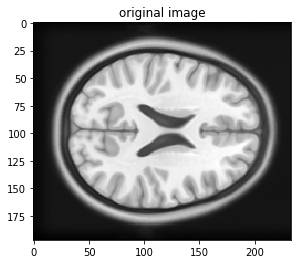

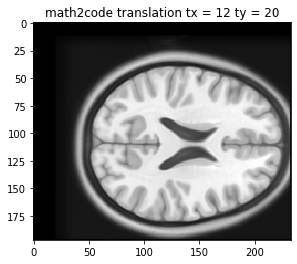

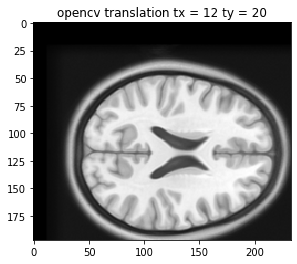

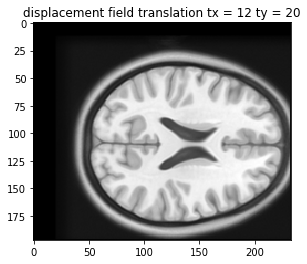

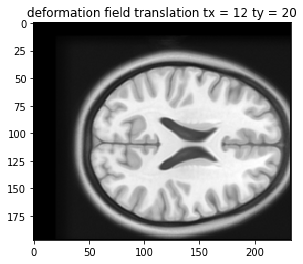

In [3]:
# example of translation transform
plt.figure()
plt.title("original image")
plt.imshow(img1)

# shift 12 in x axis, and 20 in y axis
tx = 12 # move the pixels to the right
ty = 20 # move the pixels up

# math to code
def ia_translation_transform(t_x,t_y):
    transform_matrix = np.float32([ [1, 0, t_x],  
                                    [0, 1, t_y],
                                    [0, 0,  1] ])
    return transform_matrix

def apply2DTransform(img, tMatrix):
    dims = 2 # for 3D we use 3
    displacementField = np.zeros((dims,img.shape[0],img.shape[1]))
    deformationField  = np.zeros((dims,img.shape[0],img.shape[1]))

    transformed_image = np.zeros(img.shape)
    # input an image and a transformation matrix
    for x in range(img.shape[0]):
        for y in  range(img.shape[1]):
            p = np.matmul (tMatrix , [x,y,1])
            
            # we need interpolation here              
            nx  = int(p[0]);    
            if nx>=img.shape[0]:
                nx= img.shape[0]-1
            elif nx<0:
                nx= 0

            ny  = int(p[1]);
            if ny>=img.shape[1]:
                ny= img.shape[1]-1    
            elif ny<0:
                ny = 0
            # note: since this is only translation transform, all values of
            #       the displacement field are the same e.g. tx,ty      
            displacementField [0,x,y] = nx-x ;  displacementField [1,x,y] = ny-y            
            deformationField  [0,x,y] = nx ;    deformationField  [1,x,y] = ny
            transformed_image[nx,ny] = img[x,y]        
     
    return transformed_image, displacementField, deformationField

def applyTransformationField(img,field,isDisplacement=1):
    # isDisplacement=0 : apply deformation field
    # isDisplacement=1 : apply displacement field

    transformed_image = np.zeros(img.shape)
    for x in range(img.shape[0] ):
        for y in  range(img.shape[1]):
            # apply displacement field
            if isDisplacement:
                nx  = int(x + field[0,x,y])
                ny  = int(y + field[1,x,y])
                #print(x,y,nx,ny)
                transformed_image[nx,ny] = img[x,y]        
            else:
                # apply deformation field
                nx = int(field[0,x,y]);
                ny = int(field[1,x,y]);
                transformed_image[nx,ny] = img[x,y]        

    return transformed_image
    

# tMatrix   =   ia_translation_transform(tx,ty)
# print(tMatrix)
# p = [2,3,1]
# pp = np.matmul (tMatrix , p)
# print(pp)

# print(ok)

tMatrix   =   ia_translation_transform(tx,ty)

out_image,disf,deff = apply2DTransform(img1, tMatrix)

plt.figure()
plt.title("math2code translation tx = "+ str(tx)+" ty = "+ str(ty))
plt.imshow(out_image)

# openCV ----------------------------
tMatrix = np.float32([	[1, 0, tx],
                        [0, 1, ty]])             
out_image = cv2.warpAffine(img1, tMatrix, (img1.shape[1], img1.shape[0]))

plt.figure()
plt.title("opencv translation tx = "+ str(tx)+" ty = "+ str(ty))
plt.imshow(out_image)

# SimpleITK -------------------------


# plt.figure()
# plt.imshow(out_image)

# using displacement field -------------------------
out_image = applyTransformationField(img1,disf,isDisplacement=1) 
plt.figure()
plt.title("displacement field translation tx = "+ str(tx)+" ty = "+ str(ty))
plt.imshow(out_image)


# using deformation field --------------------------
out_image = applyTransformationField(img1,deff,isDisplacement=0) 
plt.figure()
plt.title("deformation field translation tx = "+ str(tx)+" ty = "+ str(ty))
plt.imshow(out_image)

# Mirror Transform (Reflection Transform)
$\textbf{Mirror (oe Reflection) transform}$ requires only the flipping axis. Hence, it needs only 2 parameters in case of a 2D image and 3 for a 3D image. 

<!--
It is a special case of the rotation transform where the angle of the rotation is known (180 degrees) and we only need to know if the direction is affected or not.
-->

Note that we can also use one parameter, e.g. integer value that has a meaning as follows: 0 for a flip around x direction, 1 for a flip around y direction, 2 for a flip around both x and y directions, etc. After that, we define this mapping in the transform function. For now, I will assume two parameters $r_x$ $r_y$ with default values [1,1] means no reflection, and negative values means reflection. 

The Matrix matrix for 2D image is:

$$
\begin{equation}
T(p,\mu)=T((x,y),(r_x,r_y))=
\end{equation}
$$

$$
\begin{bmatrix}
 r_x & 0 & 0 \\ 
 0 & r_y & 0 \\ 
 0 & 0 & 1 \\ 
\end{bmatrix}
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}
$$

Note that in the implementation we need to add a translation as the mirror will be outside the view space of the image.

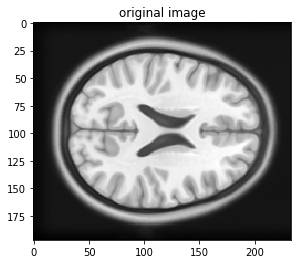

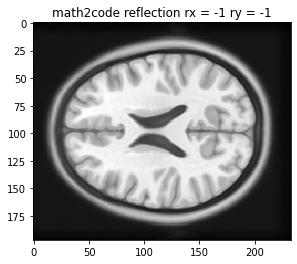

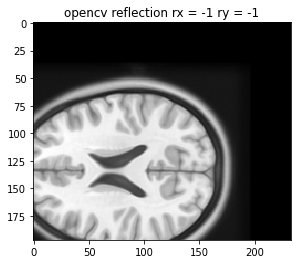

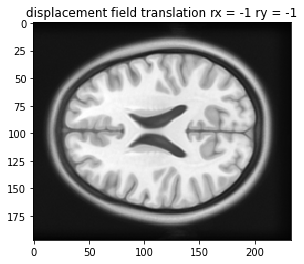

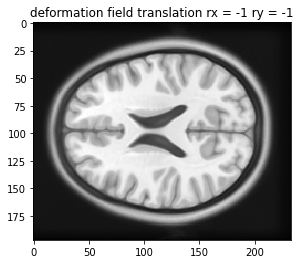

In [35]:
# example of reflection transform
plt.figure()
plt.title("original image")
plt.imshow(img1)

# shift 12 in x axis, and 20 in y axis
rx = -1 # reflection around x axis
ry = -1 # no reflection

# math to code
def ia_reflection_transform(r_x,r_y, sz):
    tr_x =  sz[0]-1 if rx <0 else 0
    tr_y =  sz[1]-1 if ry <0 else 0
    transform_matrix = np.float32([ [rx, 0, tr_x],  
                                    [0, ry, tr_y],
                                    [0, 0,  1] ])
    return transform_matrix

def apply2DTransform(img, tMatrix):
    dims = 2 # for 3D we use 3
    displacementField = np.zeros((dims,img.shape[0],img.shape[1]))
    deformationField  = np.zeros((dims,img.shape[0],img.shape[1]))

    transformed_image = np.zeros(img.shape)
    # input an image and a transformation matrix
    for x in range(img.shape[0]):
        for y in  range(img.shape[1]):
            p = np.matmul (tMatrix , [x,y,1])
            
            # we need interpolation here              
            nx  = int(p[0]);    
            if nx>=img.shape[0]:
                nx= img.shape[0]-1
            elif nx<0:
                nx= 0 # img.shape[0]-nx -3

            ny  = int(p[1]);
            if ny>=img.shape[1]:
                ny= img.shape[1]-1    
            elif ny<0:
                ny =  0 # img.shape[1]-ny -2
            # note: since this is only translation transform, all values of
            #       the displacement field are the same e.g. tx,ty      
            displacementField [0,x,y] = nx-x ;  displacementField [1,x,y] = ny-y            
            deformationField  [0,x,y] = nx ;    deformationField  [1,x,y] = ny
            #print(nx,ny)
            transformed_image[nx,ny] = img[x,y]        
     
    return transformed_image, displacementField, deformationField

def applyTransformationField(img,field,isDisplacement=1):
    # isDisplacement=0 : apply deformation field
    # isDisplacement=1 : apply displacement field

    transformed_image = np.zeros(img.shape)
    for x in range(img.shape[0] ):
        for y in  range(img.shape[1]):
            # apply displacement field
            if isDisplacement:
                nx  = int(x + field[0,x,y])
                ny  = int(y + field[1,x,y])
                #print(x,y,nx,ny)
                transformed_image[nx,ny] = img[x,y]        
            else:
                # apply deformation field
                nx = int(field[0,x,y]);
                ny = int(field[1,x,y]);
                transformed_image[nx,ny] = img[x,y]        

    return transformed_image
    

 

tMatrix   =   ia_reflection_transform(rx,ry,img1.shape)

out_image,disf,deff = apply2DTransform(img1, tMatrix)

plt.figure()
plt.title("math2code reflection rx = "+ str(rx)+" ry = "+ str(ry))
plt.imshow(out_image)

# openCV ----------------------------

# Added translation of size W-1 in x direction
tr_x =  img1.shape[0]-1 if rx <0 else 0
tr_y =  img1.shape[1]-1 if ry <0 else 0
tMatrix = np.float32([	[rx, 0, tr_x],
                        [0, ry, tr_y]])    
         
out_image = cv2.warpAffine(img1, tMatrix, (img1.shape[1], img1.shape[0]))
#out_image = cv2.flip(img1, 1)
plt.figure()
plt.title("opencv reflection rx = "+ str(rx)+" ry = "+ str(ry))
plt.imshow(out_image)

# SimpleITK -------------------------


# plt.figure()
# plt.imshow(out_image)

# using displacement field -------------------------
out_image = applyTransformationField(img1,disf,isDisplacement=1) 
plt.figure()
plt.title("displacement field translation rx = "+ str(rx)+" ry = "+ str(ry))
plt.imshow(out_image)


# using deformation field --------------------------
out_image = applyTransformationField(img1,deff,isDisplacement=0) 
plt.figure()
plt.title("deformation field translation rx = "+ str(rx)+" ry = "+ str(ry))
plt.imshow(out_image)

# Rotation Transform

This transform rotate an image counterclockwise around the origin or a specific point e.g. image center. It does not change the shapes in the image so it is also rigid transform. For 2D images, it requires only one parameter, the angle of the rotation in radian e.g. $\theta (\frac{\pi}{180})$.


The rotation matrix for 2D image:


$$
\begin{equation}
T(p,\mu)=T((x,y),(\theta))=
\end{equation}
$$

$$
\begin{bmatrix}
 \cos(\theta)&-\sin(\theta) &0 \\ 
 \sin(\theta) &\cos(\theta) &0 \\ 
 0 &  0   &1 \\ 
\end{bmatrix}
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}
$$
From the above equation, the transformed values $\tilde x$ and $\tilde y$ can be computed using: 

$$
 \tilde x   = x \ \cos(\theta) - y \ \sin(\theta) ,\\
$$

$$
 \tilde y   = x \ \sin(\theta) + y \ \cos(\theta)   \quad .\\ 
$$

For 3D rotation we have 3 rotations matrices $R_x, R_y$, and $R_Z$ with three angles $\alpha,\beta$, and $\gamma$. These three matrices are combined based on the order of the rotations. 

\begin{equation}
R_x(\alpha) = \begin{bmatrix}
  1 &  0   &0 \\ 
  0 & \cos(\alpha)&-\sin(\alpha)  \\ 
  0 & \sin(\alpha) &\cos(\alpha)  \\ 
\end{bmatrix}
\end{equation}
\begin{equation}
R_y(\beta) = \begin{bmatrix}
  \cos(\beta) &  0   &\sin(\beta) \\ 
  0 & 1  &0 \\ 
 -\sin(\beta) & 0 &\cos(\beta) \\ 
\end{bmatrix} 
\end{equation},
\begin{equation}
R_z(\gamma) = \begin{bmatrix}
 \cos(\gamma)&-\sin(\gamma) &0 \\ 
 \sin(\gamma) &\cos(\gamma) &0 \\ 
 0 &  0   &1 \\ 
\end{bmatrix}
\end{equation}


[[ 0.70710677 -0.70710677  0.        ]
 [ 0.70710677  0.70710677  0.        ]]
[[  0.70710678   0.70710678 -53.52795796]
 [ -0.70710678   0.70710678 103.77207794]]


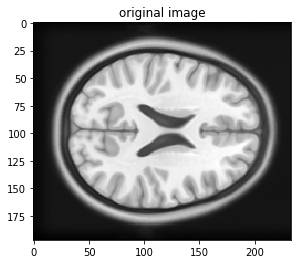

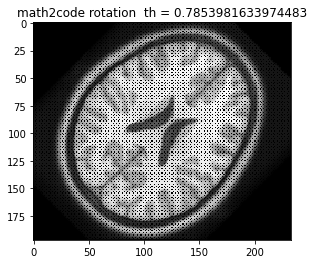

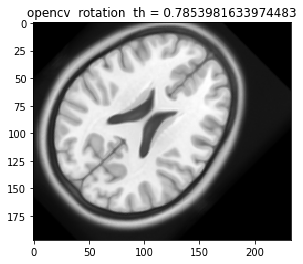

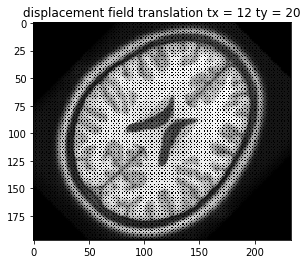

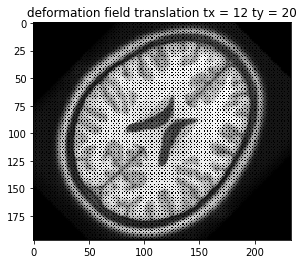

In [4]:
# example of Rotation transform
plt.figure()
plt.title("original image")
plt.imshow(img1)

# 
thD = 45 # rotate anti-clock wise th degrees around the origin 0,0
th =  45 * (math.pi /180.0 ) # to radian

# math to code
def ia_rotation_transform(th,c=[0,0]):
    tx ,ty = c
    transform_matrix = np.float32([ [math.cos(th), -math.sin(th), 0],  
                                    [math.sin(th), math.cos(th) , 0],
                                    [0, 0,  1] ])
    # around a point: T * R * -T
    t1 = -tx * math.cos(th) + ty * math.sin(th) + tx
    t2 = -tx * math.sin(th) - ty * math.cos(th) + ty
    transform_matrix2 = np.float32([ [math.cos(th), -math.sin(th), t1],  
                                      [math.sin(th), math.cos(th), t2],
                                      [0, 0,  1] ])
    return transform_matrix, transform_matrix2

def apply2DTransform(img, tMatrix):
    dims = 2 # for 3D we use 3
    displacementField = np.zeros((dims,img.shape[0],img.shape[1]))
    deformationField  = np.zeros((dims,img.shape[0],img.shape[1]))

    transformed_image = np.zeros(img.shape)
    # input an image and a transformation matrix
    for x in range(img.shape[0]):
        for y in  range(img.shape[1]):
            p = np.matmul (tMatrix , [x,y,1])
            
            # we need interpolation here              
            nx  = int(p[0]);    
            if nx>=img.shape[0]:
                nx= img.shape[0]-1
            elif nx<0:
                nx= 0

            ny  = int(p[1]);
            if ny>=img.shape[1]:
                ny= img.shape[1]-1    
            elif ny<0:
                ny = 0
    
            displacementField [0,x,y] = nx-x ;  displacementField [1,x,y] = ny-y            
            deformationField  [0,x,y] = nx ;    deformationField  [1,x,y] = ny
            transformed_image[nx,ny] = img[x,y]        
     
    return transformed_image, displacementField, deformationField


  
    return transformed_image


def applyTransformationField(img,field,isDisplacement=1):
    # isDisplacement=0 : apply deformation field
    # isDisplacement=1 : apply displacement field

    transformed_image = np.zeros(img.shape)
    for x in range(img.shape[0] ):
        for y in  range(img.shape[1]):
            # apply displacement field
            if isDisplacement:
                nx  = int(x + field[0,x,y])
                ny  = int(y + field[1,x,y])
                #print(x,y,nx,ny)
                transformed_image[nx,ny] = img[x,y]        
            else:
                # apply deformation field
                nx = int(field[0,x,y]);
                ny = int(field[1,x,y]);
                transformed_image[nx,ny] = img[x,y]        

    return transformed_image 

center = (img1.shape[0] / 2, img1.shape[1] / 2)
 
# first matrix around origin, second around image center 
tMatrix, tMatrix2   =   ia_rotation_transform(th,center)

out_image,disf,deff = apply2DTransform(img1, tMatrix2)

plt.figure()
plt.title("math2code rotation  th = "+ str(th))
plt.imshow(out_image)

# openCV ----------------------------
tMatrix = np.float32([	[math.cos(th), -math.sin(th), 0],
                        [math.sin(th), math.cos(th), 0]])             
print(tMatrix)

# Perform the rotation
origin = (0,0)
tMatrix = cv2.getRotationMatrix2D(center, thD, 1)
print(tMatrix)

out_image = cv2.warpAffine(img1, tMatrix, (img1.shape[1], img1.shape[0]))


plt.figure()
plt.title("opencv  rotation  th = "+ str(th))
plt.imshow(out_image)

# SimpleITK -------------------------


# plt.figure()
# plt.imshow(out_image)


  

# using displacement field -------------------------
out_image = applyTransformationField(img1,disf,isDisplacement=1) 
plt.figure()
plt.title("displacement field translation tx = "+ str(tx)+" ty = "+ str(ty))
plt.imshow(out_image)


# using deformation field --------------------------
out_image = applyTransformationField(img1,deff,isDisplacement=0) 
plt.figure()
plt.title("deformation field translation tx = "+ str(tx)+" ty = "+ str(ty))
plt.imshow(out_image)




# Euler Transform

$\textbf{Euler transform}$ or rigid transform combines translation and rotation together. This composite transformation, or sequence of transformations, follows the matrix multiplication order. The order of the transformation is important, e.g. rotation followed by translation is not the same as translation followed by rotation. For 2D  images, the transformation needs 3 parameters: the transformation angle theta in radians, the shift in x-coordinate and the shift in y-coordinate, e.g.  $\mu=\theta, t_x,t_y$. The rotation is counterclockwise about the origin with respect to the x-axis. To rotate a point $P$ around a specific point $P_c=(x_c,y_c)$, one first translates to -$P_c$ then rotates then translates back to $P_c$.

The transformation matrix for 2D Euler transform (rotation followed by translation):  

TODO: what is the difference in ITK between Euler and Rigid 

$$
T(p,\mu)=T((x,y),(\theta,t_x,t_y))=
\begin{bmatrix}
 1 & 0 &t_x \\ 
 0 & 1 &t_y \\ 
 0 &  0   &1 \\ 
\end{bmatrix}  
\begin{bmatrix}
 \cos(\theta)&-\sin(\theta) &0 \\ 
 \sin(\theta) &\cos(\theta) &0 \\ 
 0 &  0   &1 \\ 
\end{bmatrix} 
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}
=
\begin{bmatrix}
 \cos(\theta)&-\sin(\theta) &t_x \\ 
 \sin(\theta) &\cos(\theta) &t_y \\ 
 0 &  0   &1 \\ 
\end{bmatrix}
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}\\
$$
From the above equation, the transformed values $\tilde x$ and $\tilde y$ can be computed using: 

$$
 \tilde x   = x \ \cos(\theta) - y \ \sin(\theta) + t_x,\\
$$

$$
 \tilde y   = x \ \sin(\theta) + y \ \cos(\theta) + t_y  \quad .\\ 
$$

The above matrix applies a rotation followed by translation. For a translation followed by rotation we can write:


\begin{equation}
T(p,\mu)=T((x,y),(\theta,t_x,t_y))=
\end{equation}
$$
\begin{bmatrix}
 \cos(\theta)&-\sin(\theta) &0 \\ 
 \sin(\theta) &\cos(\theta) &0 \\ 
 0 &  0   &1 \\ 
\end{bmatrix}
\begin{bmatrix}
 1 & 0 &t_x \\ 
 0 & 1 &t_y \\ 
 0 &  0   &1 \\ 
\end{bmatrix}
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}
= 
\begin{bmatrix}
 \cos(\theta)&-\sin(\theta) &(t_x cos(\theta)-t_y sin(\theta)) \\ 
 \sin(\theta) &\cos(\theta) &(t_x sin(\theta) + t_y cos(\theta)) \\ 
 0 &  0   &1 \\ 
\end{bmatrix}
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}
$$


Here is an example: assuming a \gls{2d} point $p=(x,y)=(2,3)$ and a \gls{2d} Euler transformation parameters \gls{mu} = $(\theta, t_x,t_y)=(30,10,20)$. Rotation followed by translation produces the output point $\tilde p = (10.232,23.60)$ while translation followed by rotation produces the output point $\tilde p = (-1.11,25.9)$. To get a translation followed by rotation:
$$
\tilde x    = (x+t_x) \ \cos(\theta) - (y+t_y) \ \sin(\theta),\\
$$

$$
\tilde y    = (x+t_x) \ \sin(\theta) + (y+t_y) \ \cos(\theta),\\ 
$$

% check https://matrixcalc.org/en/
% Note: the matrix of the 2D translation transform: 
%  [ [1 0 t_x],  [1 0 t_y]  ]    [x, y, 1]

The derivative of the \gls{2d} Euler transform with respect to it parameters \gls{jmu} is:

\begin{equation}
\begin{split}
\frac{\partial T(P,\mu)}{\partial \mu}&= \frac{\partial T((x,y),(\theta,t_x,t_y))}{\partial \theta},\frac{\partial T((x,y),(\theta,t_x,t_y))}{\partial t_x},\frac{\partial T((x,y),(\theta,t_x,t_y))}{\partial t_y} \\
&=\left(\begin{bmatrix}
 -x \ \sin(\theta) - y \ \cos(\theta) \\
 x \ \cos(\theta) - y \ \sin(\theta) \\ 
\end{bmatrix}, \begin{bmatrix}
  1\\
  0\\ 
\end{bmatrix},\begin{bmatrix}
 0\\
 1\\ 
\end{bmatrix}\right)
\end{split}
\end{equation}




[[ 0.70710677 -0.70710677  0.        ]
 [ 0.70710677  0.70710677  0.        ]]
[[  0.70710678   0.70710678 -53.52795796]
 [ -0.70710678   0.70710678 103.77207794]]


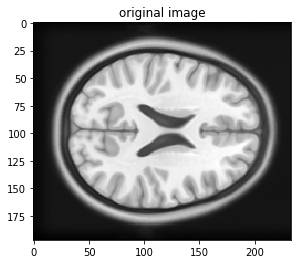

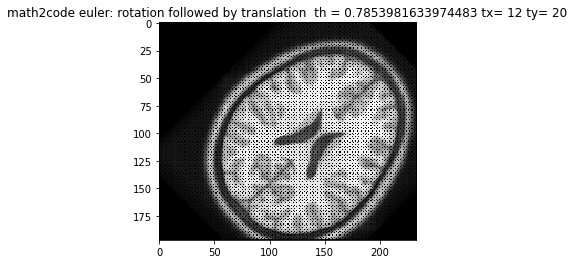

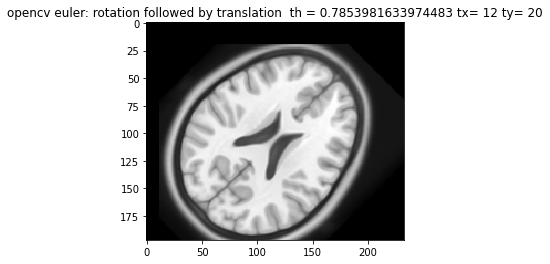

In [6]:
# example of Euler transform
plt.figure()
plt.title("original image")
plt.imshow(img1)

# rotate 45 degrees, shift 12 in x axis, and 20 in y axis 
tx = 12; ty = 20 ; t = [tx,ty]
thD = 45 # rotate anti-clock wise th degrees around the origin 0,0
th =  45 * (math.pi /180.0 ) # to radian

# math to code
def ia_euler_transform(th,t,c=[0,0]):
    tx ,ty = t
    cx,cy  = c
    transform_matrix = np.float32([ [math.cos(th), -math.sin(th), tx],  
                                    [math.sin(th), math.cos(th) , ty],
                                    [0, 0,  1] ])
    # around a point: T * R * -T
    t1 = -cx * math.cos(th) + cy * math.sin(th) + cx + tx
    t2 = -cx * math.sin(th) - cy * math.cos(th) + cy + ty 
    transform_matrix2 = np.float32([ [math.cos(th), -math.sin(th), t1],  
                                      [math.sin(th), math.cos(th), t2],
                                      [0, 0,  1] ])
    return transform_matrix, transform_matrix2

def apply2DTransform(img, tMatrix):
    dims = 2 # for 3D we use 3
    displacementField = np.zeros((dims,img.shape[0],img.shape[0]))
    transformed_image = np.zeros(img.shape)
    # input an image and a transformation matrix
    for x in range(img.shape[0]):
        for y in  range(img.shape[1]):
            p = np.matmul (tMatrix , [x,y,1])
            
            # we need interpolation here              
            nx  = int(p[0]);    
            if nx>=img.shape[0]:
                nx= img.shape[0]-1
            elif nx<0:
                nx= 0

            ny  = int(p[1]);
            if ny>=img.shape[1]:
                ny= img.shape[1]-1    
            elif ny<0:
                ny = 0

            transformed_image[nx,ny] = img[x,y]        
     
    return transformed_image

center = (img1.shape[0] / 2, img1.shape[1] / 2)
 
# first matrix around origin, second around image center 
tMatrix, tMatrix2   =   ia_euler_transform(th,[tx,ty], center)

out_image = apply2DTransform(img1, tMatrix2)

plt.figure()
plt.title("math2code euler: rotation followed by translation  th = "+ str(th) + " tx= "+str(tx)+" ty= "+str(ty))
plt.imshow(out_image)

# openCV ----------------------------
tMatrix = np.float32([	[math.cos(th), -math.sin(th), 0],
                        [math.sin(th), math.cos(th), 0]])             
print(tMatrix)

# Perform the rotation
origin = (0,0)
tMatrix = cv2.getRotationMatrix2D(center, thD, 1)

print(tMatrix)

out_image = cv2.warpAffine(img1, tMatrix, (img1.shape[1], img1.shape[0]))
tMatrix = np.float32([	[1, 0, tx],
                        [0, 1, ty]])   
out_image = cv2.warpAffine(out_image, tMatrix, (img1.shape[1], img1.shape[0]))

plt.figure()
plt.title("opencv euler: rotation followed by translation  th = "+ str(th) + " tx= "+str(tx)+" ty= "+str(ty))
plt.imshow(out_image)

# SimpleITK -------------------------


# plt.figure()
# plt.imshow(out_image)


# Similarity Transform

It is not identity transform, it is actually a non-rigid transform that adds scaling to euler transform. 

The transformation matrix:

$$
T(p,\mu)=T((x,y),(\theta,t_x,t_y))=
\begin{bmatrix}
 S_x & 0 &0  \\ 
 0 & S_y &0 \\ 
 0 &  0   &1 \\ 
\end{bmatrix}  
\begin{bmatrix}
 1 & 0 &t_x \\ 
 0 & 1 &t_y \\ 
 0 &  0   &1 \\ 
\end{bmatrix}  
\begin{bmatrix}
 \cos(\theta)&-\sin(\theta) &0 \\ 
 \sin(\theta) &\cos(\theta) &0 \\ 
 0 &  0   &1 \\ 
\end{bmatrix} 
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}
$$




[[ 1. -0.  0.]
 [ 0.  1.  0.]]
[[ 1.  0.  0.]
 [-0.  1.  0.]]


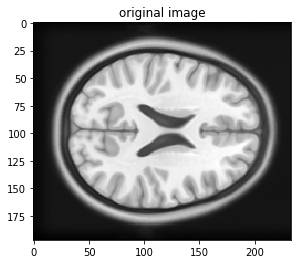

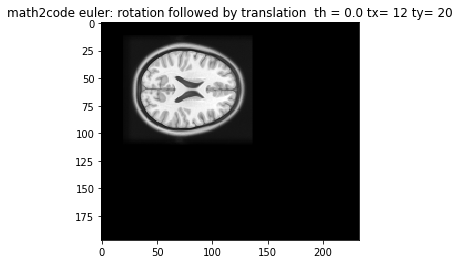

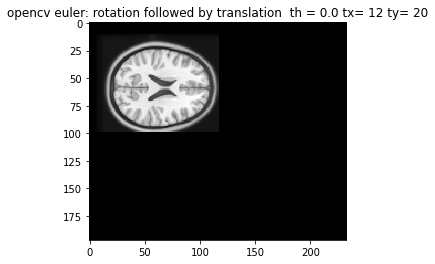

In [7]:
# example of similarity transform
plt.figure()
plt.title("original image")
plt.imshow(img1)

# rotate 45 degrees, shift 12 in x axis, and 20 in y axis 
tx = 12; ty = 20 ; t = [tx,ty]
sx =  0.5; sy = 0.5  ; s=[sx,sy] # enlarge the image two times
thD = 0 # rotate anti-clock wise th degrees around the origin 0,0
th =  thD * (math.pi /180.0 ) # to radian

# math to code
def ia_similarity_transform(th,t,s,c=[0,0]):
    tx ,ty = t
    sx,sy  = s    
    cx,cy  = c
    M_euler  = np.float32([ [math.cos(th), -math.sin(th), tx],  
                              [math.sin(th), math.cos(th) , ty],
                               [0, 0,  1] ])
    M_scaling = np.float32([  [sx , 0  , 0],  
                              [0  , sy , 0],
                              [0  , 0  , 1] ])

    transform_matrix =  np.matmul (M_euler,M_scaling)

    # around a point: T * R * -T
    t1 = -cx * math.cos(th) + cy * math.sin(th) + cx + tx
    t2 = -cx * math.sin(th) - cy * math.cos(th) + cy + ty 
    M2_euler = np.float32([ [math.cos(th), -math.sin(th), t1],  
                                      [math.sin(th), math.cos(th), t2],
                                      [0, 0,  1] ])
    
    transform_matrix2  = np.matmul (M2_euler ,M_scaling)

    return transform_matrix, transform_matrix2

def apply2DTransform(img, tMatrix):
    dims = 2 # for 3D we use 3
    displacementField = np.zeros((dims,img.shape[0],img.shape[0]))
    transformed_image = np.zeros(img.shape)
    # input an image and a transformation matrix
    for x in range(img.shape[0]):
        for y in  range(img.shape[1]):
            p = np.matmul (tMatrix , [x,y,1])
            
            # we need interpolation here              
            nx  = int(p[0]);    
            if nx>=img.shape[0]:
                nx= img.shape[0]-1
            elif nx<0:
                nx= 0

            ny  = int(p[1]);
            if ny>=img.shape[1]:
                ny= img.shape[1]-1    
            elif ny<0:
                ny = 0

            transformed_image[nx,ny] = img[x,y]        
     
    return transformed_image

center = (img1.shape[0] / 2, img1.shape[1] / 2)
 
# first matrix around origin, second around image center 
tMatrix, tMatrix2   =   ia_similarity_transform(th,[tx,ty],[sx,sy], center)

out_image = apply2DTransform(img1, tMatrix2)

plt.figure()
plt.title("math2code euler: rotation followed by translation  th = "+ str(th) + " tx= "+str(tx)+" ty= "+str(ty))
plt.imshow(out_image)

# openCV ----------------------------
tMatrix = np.float32([	[math.cos(th), -math.sin(th), 0],
                        [math.sin(th), math.cos(th), 0]])             
print(tMatrix)

# Perform the rotation
origin = (0,0)
tMatrix = cv2.getRotationMatrix2D(center, thD, 1)

print(tMatrix)

out_image = cv2.warpAffine(img1, tMatrix, (img1.shape[1], img1.shape[0]))
tMatrix = np.float32([	[1, 0, tx],
                        [0, 1, ty]])   
out_image = cv2.warpAffine(out_image, tMatrix, (img1.shape[1], img1.shape[0]))

tMatrix = np.float32([	[sx, 0, 0],
                        [0, sy, 0]])   
out_image = cv2.warpAffine(out_image, tMatrix, (img1.shape[1], img1.shape[0]))

plt.figure()
plt.title("opencv euler: rotation followed by translation  th = "+ str(th) + " tx= "+str(tx)+" ty= "+str(ty))
plt.imshow(out_image)

# SimpleITK -------------------------


# plt.figure()
# plt.imshow(out_image)


# Affine transform

[Affine transform](https://en.wikipedia.org/wiki/Affine_transformation) is a non rigid transform that adds shearing to similarity transform transform. For 2D images it has 7 parameters 2 for translation, 2 for sclaing, 2 for shearing and 1 for rotation. Notet hat the affine matrix has only 6 parameters as the 7 parameters are mixed inside it. 

$$
T(p,\mu)=T((x,y),(\theta,t_x,t_y))=
\begin{bmatrix}
 1 & 0 &t_x  \\ 
 0 & 1 &t_y \\ 
 0 &  0   &1 \\ 
\end{bmatrix} 
\begin{bmatrix}
 S_x & 0  & 0  \\ 
 0 & S_y  & 0 \\ 
 0 &  0   & 1 \\ 
\end{bmatrix} 
\begin{bmatrix}
 1    & Sh_x & 0  \\ 
 Sh_y & 1    & 0 \\ 
 0    & 0    & 1 \\ 
\end{bmatrix}  
\begin{bmatrix}
 \cos(\theta)&-\sin(\theta) &0 \\ 
 \sin(\theta) &\cos(\theta) &0 \\ 
 0 &  0   &1 \\ 
\end{bmatrix} 
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}
$$
<!-- =
\begin{bmatrix}
 \cos(\theta)&-\sin(\theta) &t_x \\ 
 \sin(\theta) &\cos(\theta) &t_y \\ 
 0 &  0   &1 \\ 
\end{bmatrix}
\begin{bmatrix}
x \\ 
y \\ 
1 \\ 
\end{bmatrix}\\ -->

where $S_x,S_y$ are teh sacaling parameters, $Sh_x,Sh_y$ are the shearing parameters.

[[ 1. -0.  0.]
 [ 0.  1.  0.]]
[[ 1.  0.  0.]
 [-0.  1.  0.]]


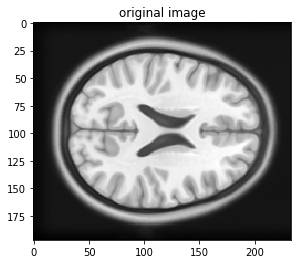

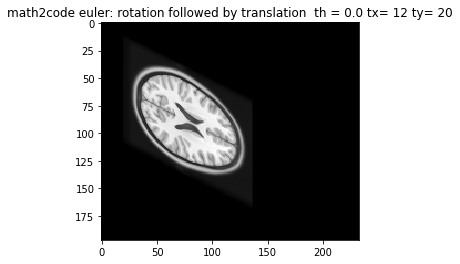

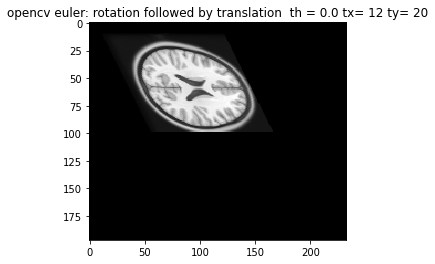

In [8]:
#affine transform
# example of similarity transform
plt.figure()
plt.title("original image")
plt.imshow(img1)

# rotate 45 degrees, shift 12 in x axis, and 20 in y axis 
tx  = 12; ty = 20 ; t = [tx,ty]
sx  =  0.5; sy = 0.5  ; s=[sx,sy] # enlarge the image two times
shx = 0.5 ; shy =0.0  ;sh =[shx,shy]
thD = 0 # rotate anti-clock wise th degrees around the origin 0,0
th =  thD * (math.pi /180.0 ) # to radian

# math to code
def ia_similarity_transform(th,t,s,sh,c=[0,0]):
    tx ,ty = t
    sx,sy  = s
    shx,shy=sh    
    cx,cy  = c
    M_euler  = np.float32([ [math.cos(th), -math.sin(th), tx],  
                              [math.sin(th), math.cos(th) , ty],
                               [0, 0,  1] ])
    M_scaling = np.float32([  [sx , 0  , 0],  
                              [0  , sy , 0],
                              [0  , 0  , 1] ])
    M_shearing = np.float32([  [1 , shx  , 0],  
                              [shy  , 1 , 0],
                              [0  , 0  , 1] ])

    transform_matrix =  np.matmul (M_euler,M_scaling)
    transform_matrix =  np.matmul (transform_matrix,M_shearing)

    # around a point: T * R * -T
    t1 = -cx * math.cos(th) + cy * math.sin(th) + cx + tx
    t2 = -cx * math.sin(th) - cy * math.cos(th) + cy + ty 
    M2_euler = np.float32([ [math.cos(th), -math.sin(th), t1],  
                                      [math.sin(th), math.cos(th), t2],
                                      [0, 0,  1] ])
    
    transform_matrix2  = np.matmul (M2_euler ,M_scaling)
    transform_matrix2  = np.matmul (transform_matrix2 ,M_shearing)
    return transform_matrix, transform_matrix2

def apply2DTransform(img, tMatrix):
    dims = 2 # for 3D we use 3
    displacementField = np.zeros((dims,img.shape[0],img.shape[0]))
    transformed_image = np.zeros(img.shape)
    # input an image and a transformation matrix
    for x in range(img.shape[0]):
        for y in  range(img.shape[1]):
            p = np.matmul (tMatrix , [x,y,1])
            
            # we need interpolation here              
            nx  = int(p[0]);    
            if nx>=img.shape[0]:
                nx= img.shape[0]-1
            elif nx<0:
                nx= 0

            ny  = int(p[1]);
            if ny>=img.shape[1]:
                ny= img.shape[1]-1    
            elif ny<0:
                ny = 0

            transformed_image[nx,ny] = img[x,y]        
     
    return transformed_image

center = (img1.shape[0] / 2, img1.shape[1] / 2)
 
# first matrix around origin, second around image center 
tMatrix, tMatrix2   =   ia_similarity_transform(th,[tx,ty],[sx,sy],[shx,shy], center)

out_image = apply2DTransform(img1, tMatrix2)

plt.figure()
plt.title("math2code euler: rotation followed by translation  th = "+ str(th) + " tx= "+str(tx)+" ty= "+str(ty))
plt.imshow(out_image)

# openCV ----------------------------
tMatrix = np.float32([	[math.cos(th), -math.sin(th), 0],
                        [math.sin(th), math.cos(th), 0]])             
print(tMatrix)

# Perform the rotation
origin = (0,0)
tMatrix = cv2.getRotationMatrix2D(center, thD, 1)

print(tMatrix)

out_image = cv2.warpAffine(img1, tMatrix, (img1.shape[1], img1.shape[0]))
tMatrix = np.float32([	[1, 0, tx],
                        [0, 1, ty]])   
out_image = cv2.warpAffine(out_image, tMatrix, (img1.shape[1], img1.shape[0]))

tMatrix = np.float32([	[sx, 0, 0],
                        [0, sy, 0]])   
out_image = cv2.warpAffine(out_image, tMatrix, (img1.shape[1], img1.shape[0]))
tMatrix = np.float32([	[1, shx, 0],
                        [shy, 1, 0]])   
out_image = cv2.warpAffine(out_image, tMatrix, (img1.shape[1], img1.shape[0]))

plt.figure()
plt.title("opencv euler: rotation followed by translation  th = "+ str(th) + " tx= "+str(tx)+" ty= "+str(ty))
plt.imshow(out_image)

# SimpleITK -------------------------


# plt.figure()
# plt.imshow(out_image)


# Quaternion (TODO)

Nice vides about this topic: [Visualizing quaternions (4d numbers) with stereographic projection
](https://www.youtube.com/watch?v=d4EgbgTm0Bg&t=0s), [Quaternions and 3d rotation, explained interactively](https://www.youtube.com/watch?v=zjMuIxRvygQ&t=21s)


**Problem with Euler angles:**


It is much easier to use quaternion to represent rotation. 



# B-Spline Transform

More details about this transform can be found in [IA_InterpolationTutorial](https://github.com/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/IA_InterpolationTutorial.ipynb)


All previous transforms are linear. This means all points of the images are affected the same way. Sometimes, it is desirable to affect different parts of the images in different way e.g. it is OK to change the shape of the lunge,heart, or muscles but bone shape in a medical images should not change.

B-spline transform is useful in this case as the deofrmation is based ona grid of control points and we can control how much deformation in any part of this grid.  

Note that the number of B-splines transform is variable. These parameters are the B-spline control points (also called B-spline coefficients) and usually they are represented as a \gls{2d} or \gls{3d} grid. This allows to transform one part or multiple parts of the image without affecting other parts by modifying only specific control-points in the grid. The size of the control-points grid is usually based on the images size so the number of parameters could reach thousands for some \gls{3d} medical images. This transform is also very useful to filter an image or compute the image gradient in a more efficient way. More information about this transform with some simple examples will be added later. 

In [9]:
# generate an image and transform it using B-Spline


# compute control points

# get a specific grid of control points

# transform the image using B-spline and the grid of the control points



[5 5]
<class 'SimpleITK.SimpleITK.Image'>
(512, 512)
(1.0, 1.0)
(0.0, 0.0)
grid_shape :  (8, 8, 2)
uv :  (8, 8, 2)
x_coeff :  64
y_coeff :  64


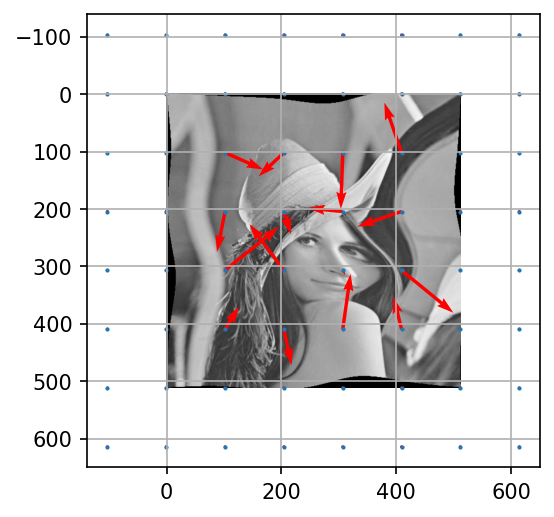

In [10]:
# # refs:
# # source: https://gist.github.com/fepegar/b723d15de620cd2a3a4dbd71e491b59d
# # https://itk.org/Doxygen44/html/classitk_1_1BSplineTransform.html
# # https://github.com/InsightSoftwareConsortium/ITK/blob/4c0982ddec474b1701d695839c78c7e888659ef4/Modules/Core/Transform/include/itkBSplineTransform.h
# # https://github.com/InsightSoftwareConsortium/ITK/blob/abefef1773a63a7db2abea363fcdbc32bb8bb0b2/Modules/Core/Transform/include/itkBSplineTransform.hxx


# create a grid
N            = 512 # 256
grid_spacing = 128 # 64

# grid = sitk.GridSource(
#        outputPixelType=sitk.sitkFloat32,
#        size=(N, N),
#        sigma=(0.5, 0.5),
#        gridSpacing=(grid_spacing, grid_spacing),
#        gridOffset=(0, 0),
#        spacing=(1, 1),
# )

# create simpleitk image from a 2d image array
grid  = sitk.GetImageFromArray(img3)
array = sitk.GetArrayViewFromImage(grid)
#fig, ax = plt.subplots(dpi=150)
#ax.imshow(  array,    interpolation='hamming',)

#ctrl_pts = np.array( [7, 7], np.uint32)
# the grid is the image, the mesh is the bspline control points matrix
# mesh size = number of control points - spline order  =[4,4]
# it should be  > spline order, more produces more deformation

ctrl_pts_size = 8
ctrl_pts = np.array( [ctrl_pts_size, ctrl_pts_size], np.uint32)
SPLINE_ORDER = 3

mesh_size    = ctrl_pts - SPLINE_ORDER 
print(mesh_size)
print(type(grid)) # itk image 
print((grid.GetSize()))
print((grid.GetSpacing()))
print((grid.GetOrigin()))

transform = sitk.BSplineTransformInitializer(grid, mesh_size.tolist())
# control points ???
params = transform.GetParameters()

grid_shape = *ctrl_pts, 2
print("grid_shape : ",grid_shape) #  [ctrl_pts_size , ctrl_pts_size, 2]


#========================================================
# create random control points to transform the image
#========================================================

 # control how much deformation
max_displacement = 100
# fill a grid with random values -0.5<=r<0.5
uv = np.random.rand(*grid_shape) - 0.5  
print("uv : ",uv.shape) # 8 8 2

# double the values
uv *= 2  # [-1, 1)
# multiplay by the max displacement
uv *= max_displacement

# no deformation at the edges
fix_edges  = 2 # zeros the control points  edges 
for i in range(fix_edges):
    uv[i, :] = 0
    uv[-1 - i, :] = 0
    uv[:, i] = 0
    uv[:, -1 - i] = 0

# # let's say no deformation at the left half
# uv [:,:4,:] = 0

#========================================================
# Apply B-spline transform
#========================================================
# use the modified control points 
transform.SetParameters(uv.flatten(order='F').tolist())

x_coeff, y_coeff = transform.GetCoefficientImages()
print("x_coeff : ",len(x_coeff))    # len = ctrl_pts_size * ctrl_pts_size
print("y_coeff : ",len(y_coeff))    # len = ctrl_pts_size * ctrl_pts_size
grid_origin  = x_coeff.GetOrigin()
grid_spacing = x_coeff.GetSpacing()

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(grid) # ???
resampler.SetTransform(transform)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(0.5)
resampler.SetOutputPixelType(sitk.sitkFloat32)
resampled = resampler.Execute(grid) # ???

array = sitk.GetArrayViewFromImage(resampled)
fig, ax = plt.subplots(dpi=150)
ax.grid()
ax.imshow(     array,    interpolation='hamming',)

x = np.linspace(grid_origin[0], grid_origin[0] + (ctrl_pts[0] - 1) * grid_spacing[0], ctrl_pts[0])
y = np.linspace(grid_origin[1], grid_origin[1] + (ctrl_pts[1] - 1) * grid_spacing[1], ctrl_pts[1])
xx, yy = np.meshgrid(x, y)
u, v = uv[..., 0].T, uv[..., 1].T
ax.quiver(xx, yy, -u, -v, color='red',   units='xy', angles='xy', scale_units='xy', scale=1)
ax.scatter(xx, yy, s=1);

# Reading and resources:

* [Insight into Images: Principles and Practice for Segmentation, Registration, and Image Analysis, July 2004.](https://dl.acm.org/doi/book/10.5555/1024225)
* [Video lecture by John Galeotti.](http://biglab.ri.cmu.edu/galeotti/methods_course/video_of_lectures_2012/Class19-720p-1Mbps.mp4)
* [ITKSoftwareGuide Book2 Ch3](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch3.html#x26-1590003.13.4).